# Resize image and add bg

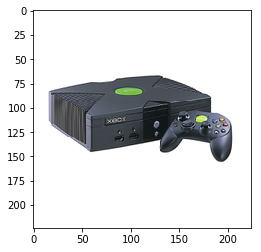

In [25]:
import matplotlib.pyplot as plt
from PIL import Image

_img = 'images/xbox.jpg'
image = Image.open(_img)
image.thumbnail((224, 224), Image.ANTIALIAS)
background = Image.new('RGB', (224, 224), (255, 255, 255))
background.paste(
    image, (int((224 - image.size[0]) / 2), int((224 - image.size[1]) / 2))
)
background.save("images/xbox_re", "JPEG")
imgplot = plt.imshow(background)

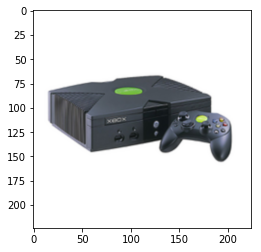

In [26]:
imgplot = plt.imshow(background, interpolation="bicubic")

# Test with pre-trained model

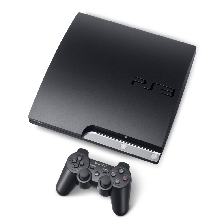

In [3]:
import tensorflow as tf

model = tf.keras.applications.VGG16()
imgfile = 'images/ps3.jpg'
image = tf.keras.preprocessing.image.load_img(
    imgfile, target_size=(224, 224))
image

In [4]:
import numpy as np

array = tf.keras.preprocessing.image.img_to_array(image)
array = np.expand_dims(array, axis=0)
# preprocess_input should be used 
array = tf.keras.applications.vgg16.preprocess_input(array)
probabilities = model.predict(array)
tf.keras.applications.vgg16.decode_predictions(probabilities)

[[('n03777754', 'modem', 0.21827507),
  ('n03832673', 'notebook', 0.09774357),
  ('n04041544', 'radio', 0.09600491),
  ('n03075370', 'combination_lock', 0.0753457),
  ('n03492542', 'hard_disc', 0.0604669)]]

# Save & restore model

In [5]:
import tensorflow as tf
import pandas as pd
import numpy as np

model = tf.keras.applications.VGG16(
    include_top=False,
    weights=None,
    input_tensor=None,
    input_shape=(224, 224, 3),
    pooling=None
#     ,classes=1000
)

In [6]:
# https://github.com/keras-team/keras/issues/4465
import tensorflow as tf
from tensorflow.python.keras.applications.vgg16 import VGG16
from tensorflow.python.keras.preprocessing import image
from tensorflow.python.keras.applications.vgg16 import preprocess_input
from tensorflow.python.keras.layers import Input, Flatten, Dense
from tensorflow.python.keras.models import Model
import numpy as np

#Get back the convolutional part of a VGG network trained on ImageNet
class_num = 10
model_vgg16_conv = VGG16(weights='imagenet', input_shape=(224, 224, 3), include_top=False)
model_vgg16_conv.summary()

#Create your own input format (here 3x224x224)
vgginput = Input(shape=(224,224,3),name = 'image_input')

#Use the generated model 
output_vgg16_conv = model_vgg16_conv(vgginput)

#Add the fully-connected layers 
x = Flatten(name='flatten')(output_vgg16_conv)
x = Dense(4096, activation='relu', name='fc1')(x)
x = Dense(4096, activation='relu', name='fc2')(x)
x = Dense(class_num, activation='softmax', name='predictions')(x)

#Create your own model 
my_model = Model(inputs=vgginput, outputs=x)
# my_model = Model(vgginput, x)

#In the summary, weights and layers from VGG part will be hidden, but they will be fit during the training
my_model.summary()


#Then training with your data ! 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

## simple save and restore
https://machinelearningmastery.com/save-load-keras-deep-learning-models/

In [3]:
import os.path 

result_path = './results'
if not os.path.isdir(result_path):
    os.makedirs(result_path)

# serialize model to JSON
model_json = my_model.to_json()
with open(os.path.join(result_path, "vgg_self_model.json"), "w") as json_file:
    json_file.write(model_json)
my_model.save_weights(os.path.join(result_path, "vgg16_self.h5"))
print("Saved model to disk")

Saved model to disk


In [7]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.python.keras.models import model_from_json

# load json and create model
json_file = open(os.path.join(result_path, 'vgg_self_model.json'), 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(os.path.join(result_path, "vgg16_self.h5"))
print("Loaded model from disk")

loaded_model.summary()

Loaded model from disk
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     (None, 224, 224, 3)       0         
_________________________________________________________________
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
fc1 (Dense)                  (None, 4096)              102764544 
_________________________________________________________________
fc2 (Dense)                  (None, 4096)              16781312  
_________________________________________________________________
predictions (Dense)          (None, 10)                40970     
Total params: 134,301,514
Trainable params: 134,301,514
Non-trainable params: 0
_______________________________________

# Freeze conv and check with tensorboard

In [28]:
# https://github.com/keras-team/keras/issues/4465
import tensorflow as tf
from tensorflow.python.keras.applications.vgg16 import VGG16
from tensorflow.python.keras.preprocessing import image
from tensorflow.python.keras.applications.vgg16 import preprocess_input
from tensorflow.python.keras.layers import Input, Flatten, Dense
from tensorflow.python.keras.models import Model
import numpy as np

#Get back the convolutional part of a VGG network trained on ImageNet
class_num = 10
model_vgg16_conv = VGG16(weights='imagenet', input_shape=(224, 224, 3), include_top=False)
for layer in model_vgg16_conv.layers:
    layer.trainable = False
model_vgg16_conv.summary()
#Create your own input format (here 3x224x224)
vgginput = Input(shape=(224,224,3),name = 'image_input')
#Use the generated model 
output_vgg16_conv = model_vgg16_conv(vgginput)

with tf.variable_scope("New_FCs"):
    #Add the fully-connected layers 
    x = Flatten(name='flatten')(output_vgg16_conv)
    x = Dense(4096, activation='relu', name='fc1')(x)
    x = Dense(4096, activation='relu', name='fc2')(x)
    x = Dense(class_num, activation='softmax', name='predictions')(x)
updatable_variables = tf.get_collection(
                        tf.GraphKeys.GLOBAL_VARIABLES,
                        scope='New_FCs')
#Create your own model 
my_model = Model(inputs=vgginput, outputs=x)
# my_model = Model(vgginput, x)
#In the summary, weights and layers from VGG part will be hidden, but they will be fit during the training
my_model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [37]:
import os
import tensorflow as tf
import time

if not(os.path.isdir("./logs")):
    os.makedirs("./logs")
# t = time.ctime(int(time.time()))
t = time.time()
file_writer = tf.summary.FileWriter('./logs/{}'.format(t), sess.graph)
# tfboard = tensorboard.TensorBoard(log_dir="./logs/{}".format(t))

AttributeError: module 'tensorboard' has no attribute 'TensorBoard'